Notebook Author: Ayana Andrews-Joseph\
**Data**: Pet Supplies Reviews from [Amazon product data](http://jmcauley.ucsd.edu/data/amazon/)\
**Provider**: Julian McAuley, USCD\
**Description**: This dataset contains product reviews and metadata from Amazon, including 142.8 million reviews spanning May 1996 - July 2014.\
This dataset includes reviews (ratings, text, helpfulness votes), product metadata (descriptions, category information, price, brand, and image features), and links (also viewed/also bought graphs).\
**5-core**: Subset of the data in which all users and items have at least 5 reviews.\
**Format**: one-review-per-lline in (loose) json.\

**Definitions**: 
> **reviewerID** - ID of the reviewer, e.g. A2SUAM1J3GNN3B \
> **asin** - ID of the product, e.g. 0000013714 \
> **reviewerName** - name of the reviewer \
> **helpful** - helpfulness rating of the review, e.g. 2/3 \
> **reviewText** - text of the review \
> **overall** - rating of the product \
> **summary** - summary of the review \
> **unixReviewTime** - time of the review (unix time) \
> **reviewTime** - time of the review (raw) 

**NOTE**: Selected a *“Small” subset for experimentation*, which uses `K-cores`. These data have been reduced to extract the k-core, such that each of the remaining users and items have k reviews each. (McAuley) The concept of a k-core was introduced to study the clustering structure of social networks and to describe the evolution of random graphs.

# Dataset

In [2]:
pip install ijson

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.3/126.3 kB 921.3 kB/s eta 0:00:00a 0:00:01


In [3]:
# Data Manipulation & Visualization
import os
import pandas as pd
import numpy as np
import ijson
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import seaborn as sns # used for plot interactive graph. 
sns.set_style('darkgrid')

In [4]:
# read in data
raw_data = pd.read_json("../input/amzn-reviews-pet-supplies/Pet_Supplies_5.json",
                        lines=True,
                        orient="columns")
print(raw_data.shape)
raw_data.head()

(157836, 9)


,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A14CK12J7C7JRK,1223000893,Consumer in NorCal,"[0, 0]",I purchased the Trilogy with hoping my two cat...,3,Nice Distraction for my cats for about 15 minutes,1294790400,"01 12, 2011"
1,A39QHP5WLON5HV,1223000893,Melodee Placial,"[0, 0]",There are usually one or more of my cats watch...,5,Entertaining for my cats,1379116800,"09 14, 2013"
2,A2CR37UY3VR7BN,1223000893,Michelle Ashbery,"[0, 0]",I bought the triliogy and have tested out all ...,4,Entertaining,1355875200,"12 19, 2012"
3,A2A4COGL9VW2HY,1223000893,Michelle P,"[2, 2]",My female kitty could care less about these vi...,4,Happy to have them,1305158400,"05 12, 2011"
4,A2UBQA85NIGLHA,1223000893,"Tim Isenhour ""Timbo""","[6, 7]","If I had gotten just volume two, I would have ...",3,You really only need vol 2,1330905600,"03 5, 2012"


In [5]:
df1 = raw_data[["helpful", "reviewText", "overall", "summary"]]

df1.head()

,helpful,reviewText,overall,summary
0,"[0, 0]",I purchased the Trilogy with hoping my two cat...,3,Nice Distraction for my cats for about 15 minutes
1,"[0, 0]",There are usually one or more of my cats watch...,5,Entertaining for my cats
2,"[0, 0]",I bought the triliogy and have tested out all ...,4,Entertaining
3,"[2, 2]",My female kitty could care less about these vi...,4,Happy to have them
4,"[6, 7]","If I had gotten just volume two, I would have ...",3,You really only need vol 2


# Overall Rating Distribution

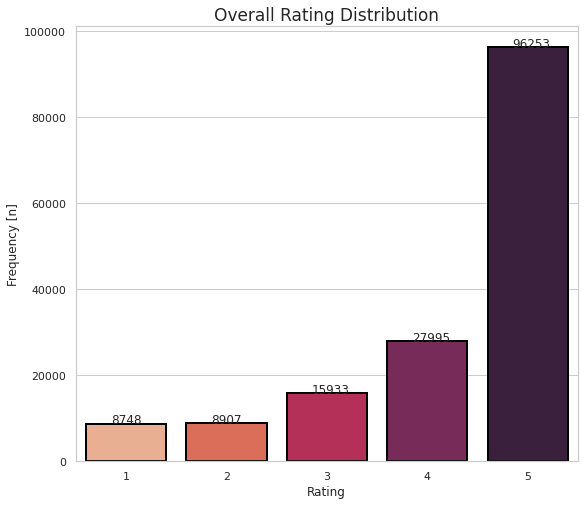

In [53]:
plt.figure(figsize=(9,8))
sns.set_theme(style="whitegrid")
ax = sns.countplot(data=df1, x="overall", edgecolor='black', linewidth=2, palette=("rocket_r"))
plt.title("Overall Rating Distribution", size = 17)
plt.xlabel('Rating')
plt.ylabel('Frequency [n]')

for p in ax.patches:
   ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+0.75))

plt.show()

### The overall rating distribution is "left-skewed", there are more 5-star ratings in comparison to the entire dataset.